# Tables and Figures
Author: Mark Bauer

In [1]:
# import packages
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import date
import cpi

plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
# reproducibility
%reload_ext watermark
%watermark -v -p duckdb,numpy,pandas,seaborn,geopandas,matplotlib,cpi

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb    : 1.0.0
numpy     : 1.23.4
pandas    : 1.5.1
seaborn   : 0.12.1
geopandas : 0.12.1
matplotlib: 3.6.2
cpi       : 2.0.6



# Introduction
The purpose of this notebook is to generate tables and figures for the repository's [README](https://github.com/mebauer/duckdb-fema-nfip/blob/main/README.md) file. Inspiration was taken from FEMA's [Historical NFIP Claims Information and Trends](https://www.floodsmart.gov/historical-nfip-claims-information-and-trends?map=countries/us/custom/us-all-territories&region=us&miny=all&maxy=all&county=&gtype=country) data visualizations. For a more thorough analysis of the NFIP, please see the [analysis-claims](https://github.com/mebauer/duckdb-fema-nfip/blob/main/analysis-claims.ipynb) or the [analysis-policies](https://github.com/mebauer/duckdb-fema-nfip/blob/main/analysis-policies.ipynb) notebooks.

In [3]:
# sanity check, list datasets
%ls data/

FimaNfipClaims.parquet       claims.db
FimaNfipPolicies.parquet     nfip.db
claims-nyc-year.parquet      policies-nyc-year.parquet
claims-state-year.parquet    policies-state-year.parquet


In [4]:
# preview size of file
!du -sh data/* | sort -rh

5.8G	data/nfip.db
3.2G	data/FimaNfipPolicies.parquet
194M	data/FimaNfipClaims.parquet
 12K	data/claims.db
8.0K	data/policies-state-year.parquet
4.0K	data/policies-nyc-year.parquet
4.0K	data/claims-state-year.parquet
4.0K	data/claims-nyc-year.parquet


# Connect to a DuckDB Persistent Database Instance

In [5]:
# create a DuckDB database instance
con = duckdb.connect("data/nfip.db")

# list tables and schemas
con.sql("SHOW ALL TABLES").df()

,database,schema,name,column_names,column_types,temporary
0,nfip,main,claims,"[agricultureStructureIndicator, asOfDate, base...","[BOOLEAN, TIMESTAMP WITH TIME ZONE, SMALLINT, ...",False
1,nfip,main,policies,"[agricultureStructureIndicator, baseFloodEleva...","[BOOLEAN, DECIMAL(8,2), SMALLINT, DATE, VARCHA...",False


In [6]:
# quick preview, sanity check
con.sql("""
    SELECT *
    FROM claims
    LIMIT 5
""").show()

┌──────────────────────┬──────────────────────┬───┬──────────────┬──────────────┬──────────────────────┐
│ agricultureStructu…  │       asOfDate       │ … │   latitude   │  longitude   │          id          │
│       boolean        │ timestamp with tim…  │   │ decimal(9,1) │ decimal(9,1) │         uuid         │
├──────────────────────┼──────────────────────┼───┼──────────────┼──────────────┼──────────────────────┤
│ false                │ NULL                 │ … │         39.2 │        -74.6 │ a4edd1e3-a2cc-4ea7…  │
│ false                │ NULL                 │ … │         29.9 │        -95.3 │ 5fa56e50-7923-44f3…  │
│ false                │ NULL                 │ … │         40.0 │        -74.1 │ ee43a296-bc2b-4b49…  │
│ false                │ NULL                 │ … │         29.9 │        -95.4 │ 2d96f6b6-d33b-4eda…  │
│ false                │ NULL                 │ … │         26.4 │        -81.9 │ 37577287-ba9f-4cea…  │
├──────────────────────┴──────────────────────┴───┴────

In [7]:
# quick preview, sanity check
con.sql("""
    SELECT *
    FROM policies
    LIMIT 5
""").show()

┌──────────────────────┬────────────────────┬───┬──────────────┬──────────────┬──────────────────────┐
│ agricultureStructu…  │ baseFloodElevation │ … │   latitude   │  longitude   │          id          │
│       boolean        │    decimal(8,2)    │   │ decimal(9,1) │ decimal(9,1) │         uuid         │
├──────────────────────┼────────────────────┼───┼──────────────┼──────────────┼──────────────────────┤
│ false                │               NULL │ … │         32.2 │       -110.9 │ c3c498e0-39ee-4642…  │
│ false                │               NULL │ … │         37.6 │       -121.0 │ 6daee4b7-308b-453c…  │
│ false                │               NULL │ … │         35.4 │       -118.9 │ d4191676-0f6d-47bf…  │
│ false                │               NULL │ … │         39.0 │       -121.4 │ 9dac717a-9a1f-4323…  │
│ false                │               NULL │ … │         34.4 │       -119.6 │ e11197ee-65ef-4630…  │
├──────────────────────┴────────────────────┴───┴──────────────┴─────────

In [8]:
# count of rows
con.sql("""
    SELECT COUNT(*) AS count_rows
    FROM claims
""").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│    2712269 │
└────────────┘



In [9]:
# count of rows
con.sql("""
    SELECT COUNT(*) AS count_rows
    FROM policies
""").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│   69489458 │
└────────────┘



In [10]:
# last refreshed
con.sql("""
    SELECT asOfDate
    FROM claims
    ORDER BY asOfDate DESC
    LIMIT 1
""").show()

┌───────────────────────────────┐
│           asOfDate            │
│   timestamp with time zone    │
├───────────────────────────────┤
│ 2025-05-09 10:37:51.032136-04 │
└───────────────────────────────┘



# Examine Dataset

## Column Info

In [11]:
# examine column datatypes
con.sql("""
    SELECT
        column_name,
        column_type
    FROM (DESCRIBE claims)
""").show(max_rows=80)

┌────────────────────────────────────────────┬──────────────────────────┐
│                column_name                 │       column_type        │
│                  varchar                   │         varchar          │
├────────────────────────────────────────────┼──────────────────────────┤
│ agricultureStructureIndicator              │ BOOLEAN                  │
│ asOfDate                                   │ TIMESTAMP WITH TIME ZONE │
│ basementEnclosureCrawlspaceType            │ SMALLINT                 │
│ policyCount                                │ SMALLINT                 │
│ crsClassificationCode                      │ SMALLINT                 │
│ dateOfLoss                                 │ DATE                     │
│ elevatedBuildingIndicator                  │ BOOLEAN                  │
│ elevationCertificateIndicator              │ VARCHAR                  │
│ elevationDifference                        │ DECIMAL(6,1)             │
│ baseFloodElevation                  

In [12]:
# examine column datatypes
con.sql("""
    SELECT
        column_name,
        column_type
    FROM (DESCRIBE policies)
""").show(max_rows=80)

┌────────────────────────────────────────┬──────────────┐
│              column_name               │ column_type  │
│                varchar                 │   varchar    │
├────────────────────────────────────────┼──────────────┤
│ agricultureStructureIndicator          │ BOOLEAN      │
│ baseFloodElevation                     │ DECIMAL(8,2) │
│ basementEnclosureCrawlspaceType        │ SMALLINT     │
│ cancellationDateOfFloodPolicy          │ DATE         │
│ condominiumCoverageTypeCode            │ VARCHAR      │
│ construction                           │ BOOLEAN      │
│ crsClassCode                           │ SMALLINT     │
│ buildingDeductibleCode                 │ VARCHAR      │
│ contentsDeductibleCode                 │ VARCHAR      │
│ elevatedBuildingIndicator              │ BOOLEAN      │
│ elevationCertificateIndicator          │ VARCHAR      │
│ elevationDifference                    │ INTEGER      │
│ federalPolicyFee                       │ SMALLINT     │
│ ratedFloodZo

In [13]:
# earliest and latest record effective date
con.sql("""
    SELECT
        min(asOfDate) AS earliestAsOfDate,
        max(asOfDate) AS latestAsOfDate
    FROM claims
""").show()

┌────────────────────────────┬───────────────────────────────┐
│      earliestAsOfDate      │        latestAsOfDate         │
│  timestamp with time zone  │   timestamp with time zone    │
├────────────────────────────┼───────────────────────────────┤
│ 2019-09-19 09:45:58.926-04 │ 2025-05-09 10:37:51.032136-04 │
└────────────────────────────┴───────────────────────────────┘



In [14]:
# earliest and latest date of loss in dataset
con.sql("""
    SELECT
        min(dateOfLoss) AS earliestDateOfLoss,
        max(dateOfLoss) AS latestDateOfLoss
    FROM claims
""").show()

┌────────────────────┬──────────────────┐
│ earliestDateOfLoss │ latestDateOfLoss │
│        date        │       date       │
├────────────────────┼──────────────────┤
│ 1978-01-01         │ 2025-05-08       │
└────────────────────┴──────────────────┘



In [15]:
# summary statistics formatted for Markdown for README
summary_claims_df = con.sql("""
    SELECT
        ROUND(COUNT(id) / 1_000_000.0, 2) AS countClaimM,
        ROUND((
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000.0, 2) AS paidTotalClaimM,
        ROUND(SUM(amountPaidOnBuildingClaim) / 1_000_000.0, 2) AS paidBuildingM,
        ROUND(SUM(amountPaidOnContentsClaim) / 1_000_000.0, 2) AS paidContentsM,
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim) / 1_000_000.0, 2) AS paidICCM
    FROM claims
""").df()

# print as Markdown for easy README insertion
print(summary_claims_df.to_markdown(index=False, floatfmt=",.2f"))

|   countClaimM |   paidTotalClaimM |   paidBuildingM |   paidContentsM |   paidICCM |
|--------------:|------------------:|----------------:|----------------:|-----------:|
|          2.71 |         88,145.83 |       71,665.54 |       15,528.23 |     952.06 |


In [16]:
# summary statistics formatted for Markdown for README
summary_policies_df = con.sql("""
    SELECT
        SUM(policyCount)::BIGINT AS policiesInForce,
        ROUND(SUM(totalBuildingInsuranceCoverage + totalContentsInsuranceCoverage) / 1_000_000.0, 2) AS totalInsuranceCoverageM,
        ROUND(SUM(totalInsurancePremiumOfThePolicy) / 1_000_000.0, 2) AS totalInsurancePremiumOfThePolicyM,
        ROUND(SUM(policyCost) / 1_000_000.0, 3) AS policyCostM
    FROM policies
    WHERE policyTerminationDate > '2025-05-14'
""").df()

# print as Markdown for easy README insertion
print(summary_policies_df.to_markdown(index=False, floatfmt=",.2f"))

|   policiesInForce |   totalInsuranceCoverageM |   totalInsurancePremiumOfThePolicyM |   policyCostM |
|------------------:|--------------------------:|------------------------------------:|--------------:|
|      4,469,069.00 |              1,229,228.66 |                            3,874.69 |      5,047.91 |


In [17]:
ls data/

FimaNfipClaims.parquet       claims.db
FimaNfipPolicies.parquet     nfip.db
claims-nyc-year.parquet      policies-nyc-year.parquet
claims-state-year.parquet    policies-state-year.parquet


In [18]:
claims_year = con.sql("""
    SELECT
        yearOfLoss,
        COUNT(*) AS countClaims
    FROM claims
    WHERE yearOfLoss BETWEEN 2009 AND 2024
    GROUP BY yearOfLoss
    ORDER BY yearOfLoss
""").df()

claims_year

,yearOfLoss,countClaims
0,2009,37734
1,2010,37818
2,2011,96466
3,2012,175804
4,2013,24062
5,2014,18772
6,2015,34581
7,2016,85496
8,2017,145679
9,2018,42623


In [19]:
policies_year = con.sql("""
    SELECT
        strftime('%Y', CAST(policyEffectiveDate AS TIMESTAMP))::INT AS policyEffectiveYear,
        SUM(policyCount)::BIGINT / 1_000_000.0 AS countPoliciesM
    FROM policies
    WHERE policyEffectiveYear BETWEEN 2009 AND 2024
    GROUP BY policyEffectiveYear
    ORDER BY policyEffectiveYear
""").df()

policies_year

,policyEffectiveYear,countPoliciesM
0,2009,5.712917
1,2010,5.661703
2,2011,5.680679
3,2012,5.641407
4,2013,5.647055
5,2014,5.525767
6,2015,5.257480
7,2016,5.233261
8,2017,5.205874
9,2018,5.187350


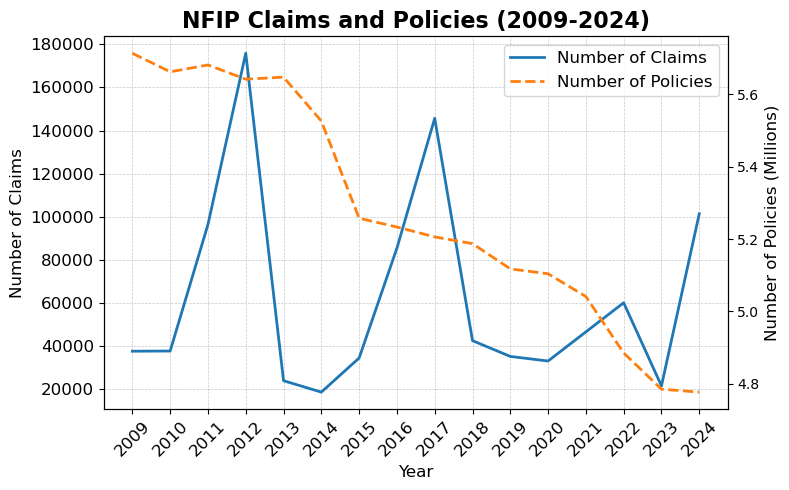

In [20]:
# create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot the number of claims (count_year) on the first axis with a thicker line
sns.lineplot(
    data=claims_year,
    x='yearOfLoss',
    y='countClaims',
    ax=ax1,
    color='C0',
    linewidth=2,  # thicker line for better visibility
    label='Number of Claims'  # add a label for the legend
)

# create a second y-axis for the amount paid (total_claim)
ax2 = ax1.twinx()

# plot the total claim amount (total_claim) on the second axis with a different line style
sns.lineplot(
    data=policies_year,
    x='policyEffectiveYear',
    y='countPoliciesM',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  # Dashed line for differentiation
    label='Number of Policies'
)

# set the title and labels with clear and concise text
ax1.set_title('NFIP Claims and Policies (2009-2024)', fontsize=16, weight='bold')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Claims', fontsize=12)
ax2.set_ylabel('Number of Policies (Millions)', fontsize=12)

# set the x-axis major and minor ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# improve tick label formatting
ax1.tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability
ax1.tick_params(axis='both', which='major', labelsize=12)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# combine the legends from both axes and put them in the upper left
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine the handles and labels from both axes
ax1.legend(handles + handles2, labels + labels2, fontsize=12)
ax2.legend().set_visible(False)

# tight layout to adjust spacing
plt.tight_layout()
plt.savefig('figures/claims-policies-year.png', bbox_inches='tight', dpi=200)

In [21]:
claims_year = con.sql("""
    SELECT
        UPPER(state) AS state,
        yearOfLoss,
        COUNT(*) AS countClaims
    FROM claims
    WHERE yearOfLoss BETWEEN 2009 AND 2024
    GROUP BY ALL
    ORDER BY state, yearOfLoss
""").df()

claims_year

,state,yearOfLoss,countClaims
0,AK,2009,17
1,AK,2010,2
2,AK,2011,7
3,AK,2012,66
4,AK,2013,46
...,...,...,...
855,WY,2019,20
856,WY,2021,2
857,WY,2022,2
858,WY,2023,13


In [22]:
policies_year = con.sql("""
    SELECT
        UPPER(propertyState) AS state,
        strftime('%Y', CAST(policyEffectiveDate AS TIMESTAMP))::INT AS policyEffectiveYear,
        SUM(policyCount)::BIGINT AS countPolicies
    FROM policies
    WHERE policyEffectiveYear BETWEEN 2009 AND 2024
    GROUP BY ALL
    ORDER BY state, policyEffectiveYear
""").df()

policies_year

,state,policyEffectiveYear,countPolicies
0,AK,2009,2926
1,AK,2010,2943
2,AK,2011,3068
3,AK,2012,3148
4,AK,2013,3245
...,...,...,...
892,WY,2020,1709
893,WY,2021,1668
894,WY,2022,1689
895,WY,2023,1741


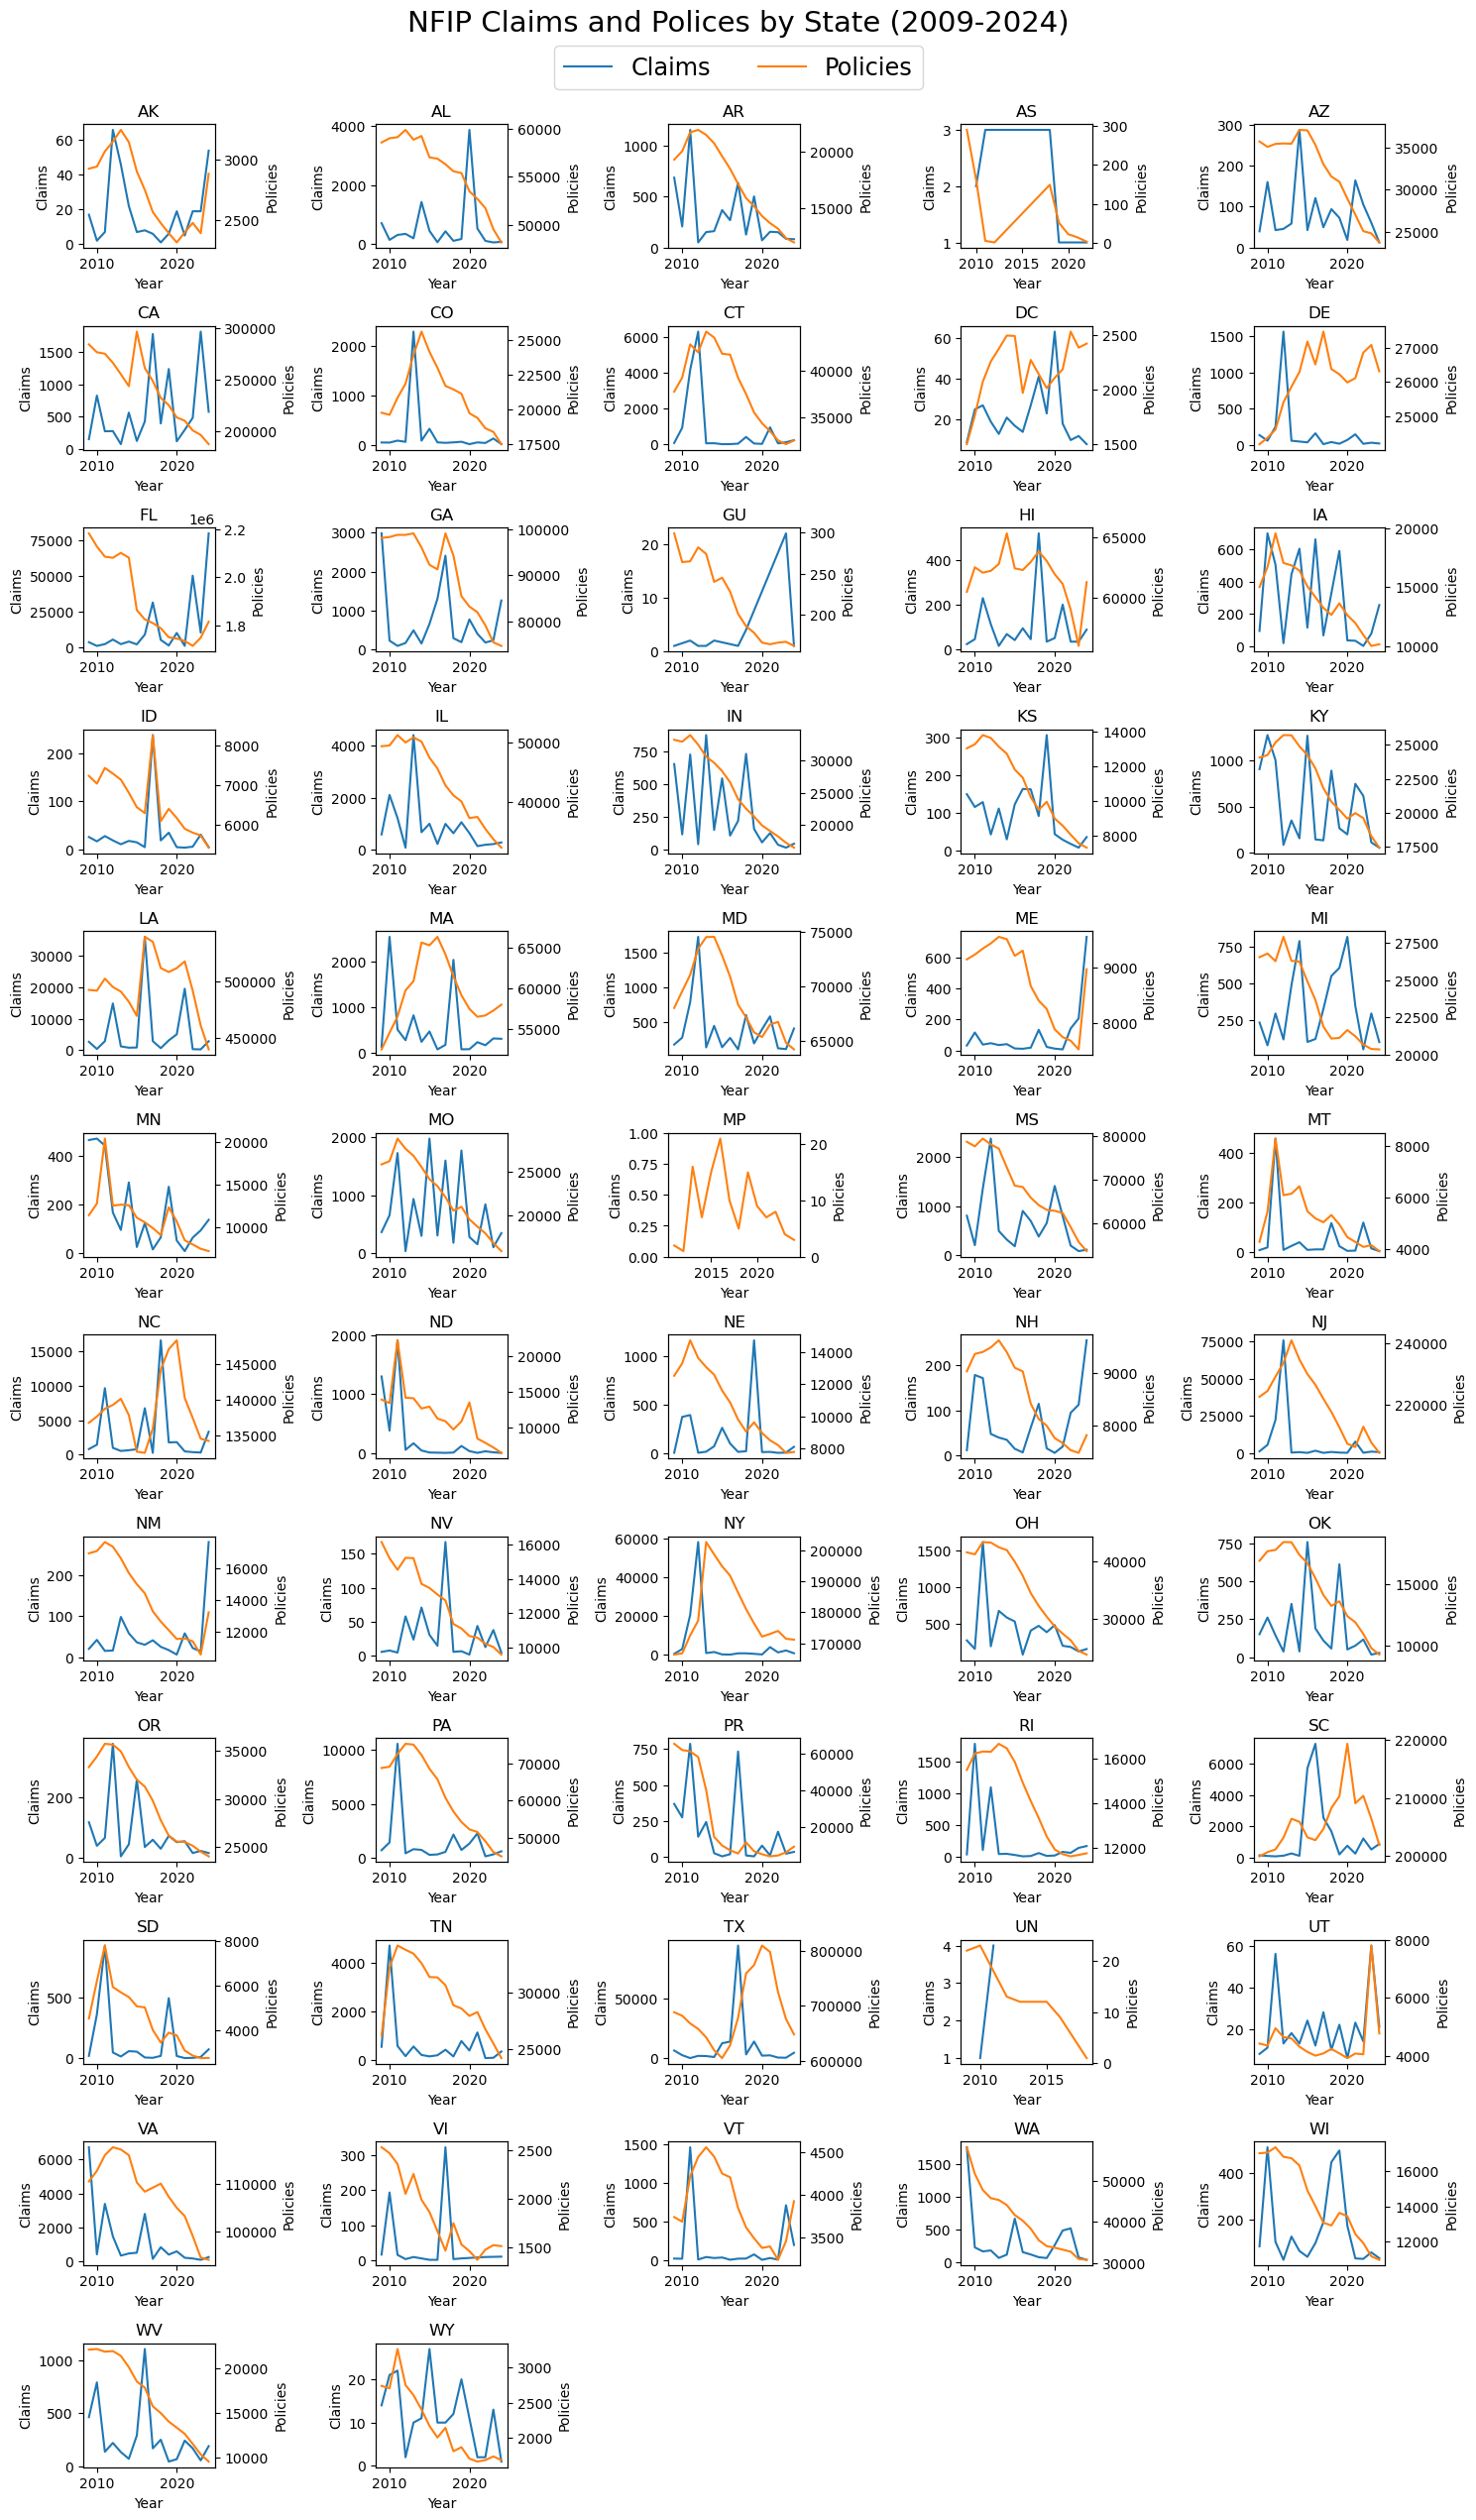

In [23]:
states_list = policies_year['state'].unique()

fig, axs = plt.subplots(12, 5, figsize=(15, 25))
axs = axs.flatten()

claim_line = None
policy_line = None

for state, ax in zip(states_list, axs):
    claims = claims_year[claims_year['state'] == state]
    policies = policies_year[policies_year['state'] == state]

    if not claims.empty:
        claim_plot = claims.plot(
            x='yearOfLoss', y='countClaims', ax=ax,
            color='tab:blue', legend=False
        )
        if claim_line is None:
            claim_line = claim_plot.get_lines()[0]

    ax2 = ax.twinx()
    if not policies.empty:
        policy_plot = policies.plot(
            x='policyEffectiveYear', y='countPolicies', ax=ax2,
            color='tab:orange', legend=False
        )
        if policy_line is None:
            policy_line = policy_plot.get_lines()[0]

    ax.set_title(state)
    ax.set_xlabel('Year')
    ax.set_ylabel('Claims')
    ax2.set_ylabel('Policies')

for ax in axs[len(states_list):]:
    ax.set_visible(False)
    
fig.legend(
    [claim_line, policy_line],
    ['Claims', 'Policies'],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.005),
    fontsize='xx-large',
    ncol=2
)

fig.suptitle("NFIP Claims and Polices by State (2009-2024)", y=1.015, fontsize=21)
fig.tight_layout()
plt.savefig('figures/state-year.png', bbox_inches='tight', dpi=200)

Similar plot as above, but now the counts are on the same axis.

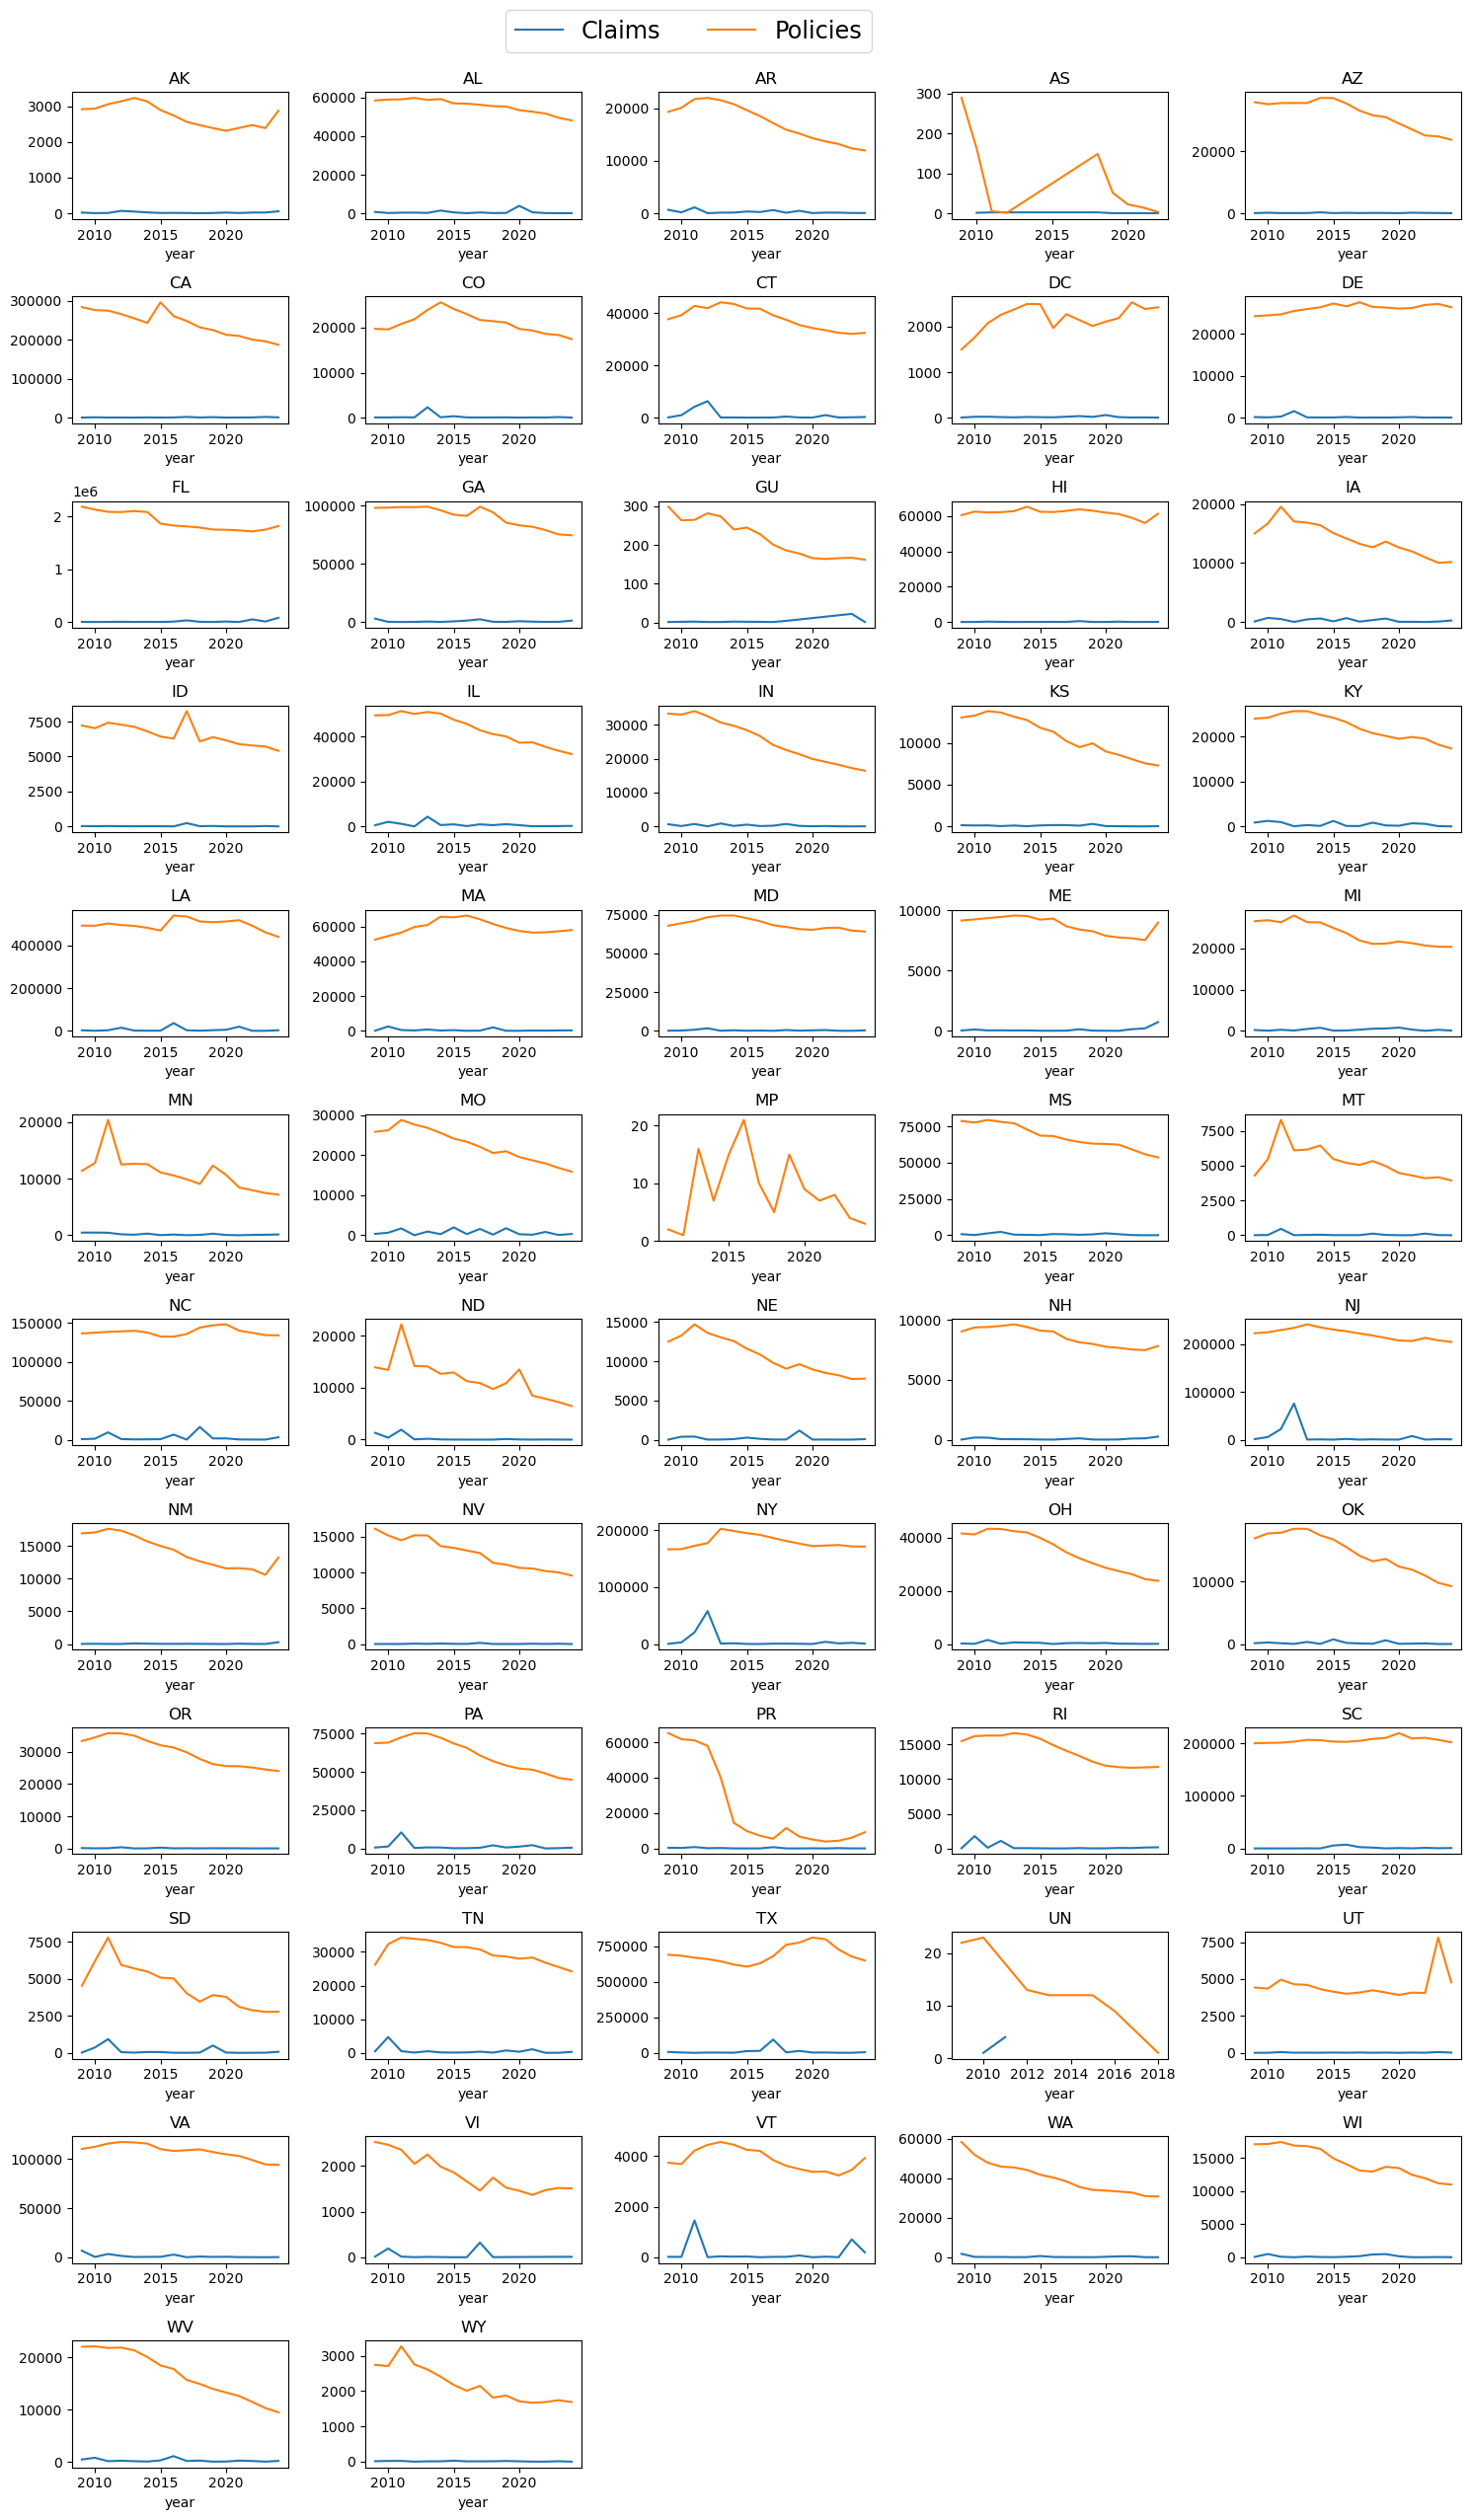

In [24]:
states_list = policies_year['state'].unique()

fig, axs = plt.subplots(12, 5, figsize=(15, 25))

for state, ax in zip(states_list, axs.flat):
    
    (claims_year
     .loc[claims_year['state'] == state]
     .plot(x='yearOfLoss', y='countClaims', legend=False, ax=ax)
    )
    
    (policies_year
     .loc[policies_year['state'] == state]
     .plot(x='policyEffectiveYear', y='countPolicies', legend=False, ax=ax)
    )
    
    ax.set_title(state)
    ax.set_xlabel('year')
    
for ax in axs.flat[len(states_list):]:
    ax.set_visible(False)  
    
fig.legend(
    ['Claims', 'Policies'],
    ncol=2, bbox_to_anchor=(0.60, 1.024), fontsize='xx-large')   
    
fig.tight_layout()

In [25]:
year_loss_df = con.sql("""
    SELECT
        yearOfLoss,
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim
    FROM claims 
    WHERE yearOfLoss < 2025
    GROUP BY yearOfLoss 
   ORDER BY yearOfLoss
""").df()

# adjust for inflation in 2024 dollars
year_loss_df["paidTotalClaim2024"] = year_loss_df.apply(
    lambda x: cpi.inflate(
        x.paidTotalClaim,
        x.yearOfLoss,
        to=2024),
    axis=1
)

# transform to millions
year_loss_df = year_loss_df.assign(
    paidTotalClaimM = year_loss_df['paidTotalClaim'] / 1_000_000,
    paidTotalClaim2024M = year_loss_df['paidTotalClaim2024'] / 1_000_000
)

# preview
print(year_loss_df.shape)
year_loss_df.head()

(47, 6)


,yearOfLoss,countClaims,paidTotalClaim,paidTotalClaim2024,paidTotalClaimM,paidTotalClaim2024M
0,1978,35897,147719253,7.107041e+08,147.719253,710.704061
1,1979,87375,483281219,2.088154e+09,483.281219,2088.154302
2,1980,53227,230414295,8.771654e+08,230.414295,877.165410
3,1981,31174,127118031,4.386747e+08,127.118031,438.674676
4,1982,43106,198295820,6.445929e+08,198.295820,644.592927


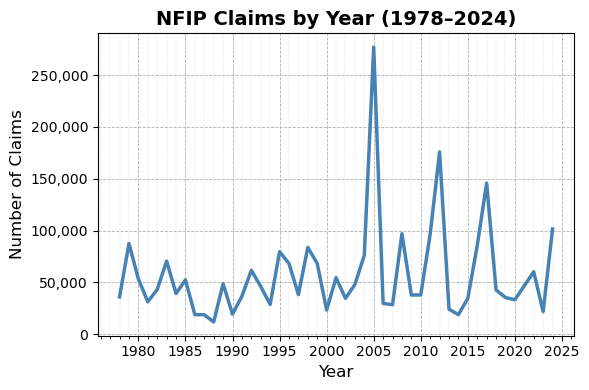

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='countClaims',
    ax=ax,
    linewidth=2.5,
    color='steelblue'
)

ax.set_title("NFIP Claims by Year (1978–2024)", fontsize=14, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Claims", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.grid(True, which='major', linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

plt.tight_layout()
plt.savefig('figures/year-count.png', dpi=200, bbox_inches='tight')

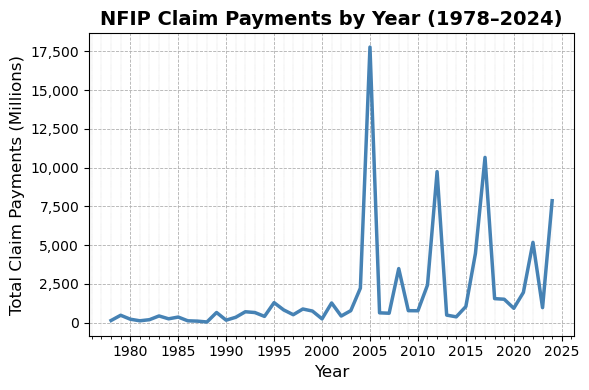

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='paidTotalClaimM',
    ax=ax,
    linewidth=2.5,
    color='steelblue'
)

ax.set_title("NFIP Claim Payments by Year (1978–2024)", fontsize=14, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total Claim Payments (Millions)", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.grid(True, which='major', linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

plt.tight_layout()

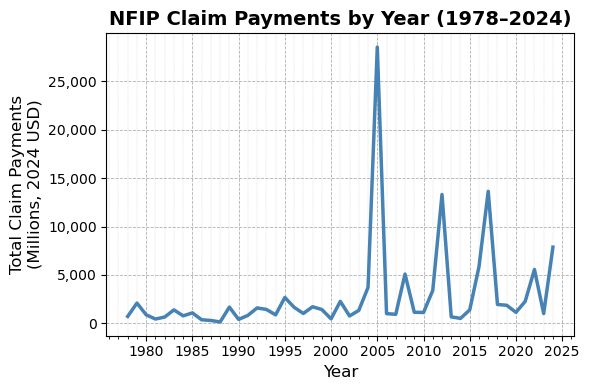

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='paidTotalClaim2024M',
    ax=ax,
    linewidth=2.5,
    color='steelblue'
)

ax.set_title(
    "NFIP Claim Payments by Year (1978–2024)",
    fontsize=14,
    weight='bold'
)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total Claim Payments\n(Millions, 2024 USD)", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.grid(True, which='major', linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

plt.tight_layout()
plt.savefig('figures/year-amount-paid.png', dpi=300, bbox_inches='tight')

# Top 10 Most Significant Flood Events By Total Amount Paid

In [29]:
event_df = con.sql("""
    SELECT
        yearOfLoss,
        floodEvent,
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim
    FROM claims 
    WHERE floodEvent NOT NULL
    GROUP BY yearOfLoss, floodEvent    
""").df()

print(event_df.shape)
event_df.head()

(240, 4)


,yearOfLoss,floodEvent,countClaims,paidTotalClaim
0,2005,Hurricane Katrina,208348,16261697056
1,2003,Hurricane Isabel,23955,500076497
2,1990,Flooding,6719,84832693
3,2016,Spring severe storms,8433,472881300
4,1983,Hurricane Alicia,14072,114264956


In [30]:
event_df['yearOfLossFormatted'] = pd.to_datetime(event_df['yearOfLoss'].astype(str) + "-01-01")

# adjust to price level as of January 2025
timestamp = pd.Timestamp(date(2025, 1, 1))

event_df["paidTotalClaim2025"] = event_df.apply(
    lambda x: cpi.inflate(
        x.paidTotalClaim,
        x.yearOfLossFormatted,
        to=timestamp),
    axis=1
)

event_df.head(10)

,yearOfLoss,floodEvent,countClaims,paidTotalClaim,yearOfLossFormatted,paidTotalClaim2025
0,2005,Hurricane Katrina,208348,16261697056,2005-01-01,2.708899e+10
1,2003,Hurricane Isabel,23955,500076497,2003-01-01,8.742972e+08
2,1990,Flooding,6719,84832693,1990-01-01,2.115297e+08
3,2016,Spring severe storms,8433,472881300,2016-01-01,6.340672e+08
4,1983,Hurricane Alicia,14072,114264956,1983-01-01,3.711520e+08
5,1992,Hurricane Andrew,11700,169213931,1992-01-01,3.892423e+08
6,2003,Hurricane Claudette,1451,11525780,2003-01-01,2.015083e+07
7,1992,December Storm - Nor'easter,30314,346119922,1992-01-01,7.961786e+08
8,2024,Hurricane Helene,57843,6027667592,2024-01-01,6.208527e+09
9,2015,October severe storms,6071,150725130,2015-01-01,2.048762e+08


In [31]:
# transform raw dollars to millions and calculate average paid claim
event_df = (
    event_df
    .assign(
        paidTotalClaimM = event_df['paidTotalClaim'] / 1_000_000,
        paidTotalClaimM2025 = event_df['paidTotalClaim2025'] / 1_000_000,
        averagePaidClaim2025 = event_df['paidTotalClaim2025'] / event_df['countClaims']
    )
    .astype({'averagePaidClaim2025':int})
    
    # sort by top 10 events on paid claims in 2025 dollars    
    .sort_values(by='paidTotalClaim2025', ascending=False)
    .head(10)
    .reset_index(drop=True) 
)

# add rank of events
event_df['rank'] = range(1, 11)

# rearrange columns
cols = [
    'rank', 'yearOfLoss', 'floodEvent',
    'countClaims', 'paidTotalClaimM',
    'paidTotalClaimM2025', 'averagePaidClaim2025'
]
 
event_df = event_df.loc[:, cols]

# preview
event_df

,rank,yearOfLoss,floodEvent,countClaims,paidTotalClaimM,paidTotalClaimM2025,averagePaidClaim2025
0,1,2005,Hurricane Katrina,208348,16261.697056,27088.985661,130017
1,2,2012,Hurricane Sandy,144848,8957.466107,12553.888848,86669
2,3,2017,Hurricane Harvey,92398,9055.711922,11846.272889,128209
3,4,2024,Hurricane Helene,57843,6027.667592,6208.526740,107334
4,5,2022,Hurricane Ian,48754,4838.681069,5467.258006,112139
5,6,2008,Hurricane Ike,58126,2702.511916,4067.224099,69972
6,7,2016,Mid-summer severe storms,30018,2533.534783,3397.113441,113169
7,8,2004,Hurricane Ivan,20137,1325.419294,2273.473394,112900
8,9,2001,Tropical Storm Allison,35561,1104.979705,2004.683083,56373
9,10,2011,Hurricane Irene,52493,1347.399996,1943.620349,37026


In [32]:
# convert to Markdown for README display
print(event_df.to_markdown(index=False, floatfmt=".2f"))

|   rank |   yearOfLoss | floodEvent               |   countClaims |   paidTotalClaimM |   paidTotalClaimM2025 |   averagePaidClaim2025 |
|-------:|-------------:|:-------------------------|--------------:|------------------:|----------------------:|-----------------------:|
|      1 |         2005 | Hurricane Katrina        |        208348 |          16261.70 |              27088.99 |                 130017 |
|      2 |         2012 | Hurricane Sandy          |        144848 |           8957.47 |              12553.89 |                  86669 |
|      3 |         2017 | Hurricane Harvey         |         92398 |           9055.71 |              11846.27 |                 128209 |
|      4 |         2024 | Hurricane Helene         |         57843 |           6027.67 |               6208.53 |                 107334 |
|      5 |         2022 | Hurricane Ian            |         48754 |           4838.68 |               5467.26 |                 112139 |
|      6 |         2008 | Hurrican

# Maps

In [33]:
# count claims by state
state_loss_df = con.sql("""
    SELECT
        state,
        COUNT(id) AS countClaim
    FROM claims  
    GROUP BY state
    ORDER BY state ASC  
""").df()

print(state_loss_df.shape)
state_loss_df.head()

(57, 2)


,state,countClaim
0,AK,778
1,AL,44835
2,AR,10189
3,AS,29
4,AZ,5264


In [34]:
# read states shapefile
path = 'https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip'
states_gdf = gpd.read_file(path)

# sanity check
print(states_gdf.shape)
states_gdf.head()

(56, 16)


,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998..."
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243..."


In [35]:
# identify CRS
states_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [36]:
# merge nfip claims to state boundaries
states_merged = states_gdf.merge(
    state_loss_df,
    left_on='STUSPS',
    right_on='state',
    how='left'
)

# sanity check
states_merged.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,27731
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,447278
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,52538
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998...",MN,12454
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,25218


In [37]:
# examine NULLS count
states_merged.loc[states_merged['state'].isnull()]

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim


In [38]:
# calculate clount claims per kilometer and convert land area (sq meters) to sq kilometers
states_merged['claims_per_1000km2'] = states_merged['countClaim'] / (states_merged['ALAND'] / 1_000_000) * 1000

# preview
states_merged.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim,claims_per_1000km2
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,27731,445.359867
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,447278,3218.666419
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,52538,365.409631
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998...",MN,12454,60.384624
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,25218,1002.634566


In [39]:
# locate conus only gdf
conus_gdf = states_merged.loc[
    (states_merged['GEOID'].astype(int) <= 56)
    & (~states_merged['GEOID'].isin(['02', '15']))
]

# transform CRS for display
conus_gdf = conus_gdf.to_crs(5070)

conus_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim,claims_per_1000km2
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((1548777.304 1961418.875, 1548791.323...",WV,27731,445.359867
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((1318717.052 267177.248, 131868...",FL,447278,3218.666419
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((701650.471 1724476.457, 701575.841 1...",IL,52538,365.409631
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((50386.396 2888284.096, 50544.128 288...",MN,12454,60.384624
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((1718035.440 1986172.419, 1718118.217...",MD,25218,1002.634566


In [40]:
# identify bounds of map for value scale
conus_gdf['countClaim'].describe()

count        49.000000
mean      54288.489796
std      108108.033186
min         488.000000
25%        5733.000000
50%       14710.000000
75%       49506.000000
max      484666.000000
Name: countClaim, dtype: float64

In [41]:
# function to plot non-conus states
def plot_states(geoid, crs, ax, title):
    
    (states_merged
    .loc[states_merged['GEOID'].isin([geoid])]
    .to_crs(crs)
    .plot(
        column='countClaim',
        legend=True,
        cmap=cmap,
        cax=cax,
        norm=norm,
        ax=ax,
        edgecolor='black'
    )
    .set_title(title, fontsize=7)
)

/var/folders/2_/t32jmn4n7cs9v7ll96cqlmn00000gn/T/ipykernel_5706/3581116447.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


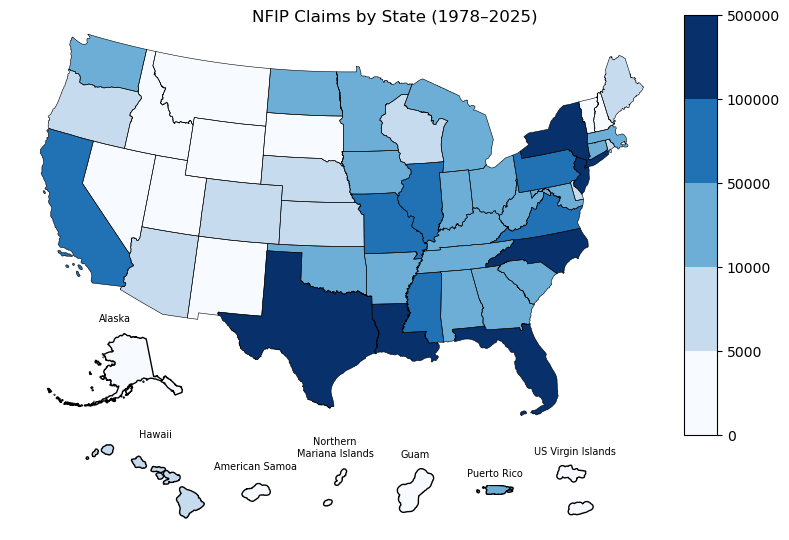

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(
    [0, 5_000, 10_000, 50_000, 100_000, 500_000],
    cmap.N
)

# plot conus values
conus_gdf.plot(
    column='countClaim',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.05, 0.25, 0.2, 0.1])
hawaii = fig.add_axes([.0, 0.1, 0.4, 0.15])
ams = fig.add_axes([.30, 0.1, 0.05, 0.1])
mp = fig.add_axes([.40, 0.1, 0.05, 0.1])
gu = fig.add_axes([.50, 0.1, 0.05, 0.1])
pr = fig.add_axes([.60, 0.1, 0.05, 0.1])
vi = fig.add_axes([.70, 0.1, 0.05, 0.1])

# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(700_000)
hawaii.set_ylim(bottom=None, top=1_000_000)
hawaii.set_title('Hawaii', y=.7, fontsize=7)
alaska.axis('off')

fig.suptitle('NFIP Claims by State (1978–2025)', y=.75)
fig.tight_layout()
fig.savefig('figures/count-claims-map.png', dpi=200, bbox_inches='tight')

In [43]:
# identify bounds of map
conus_gdf['claims_per_1000km2'].describe()

count       49.000000
mean       800.686786
std       1721.319081
min          2.215080
25%         60.384624
50%        164.112938
75%        635.784549
max      10565.544769
Name: claims_per_1000km2, dtype: float64

/var/folders/2_/t32jmn4n7cs9v7ll96cqlmn00000gn/T/ipykernel_5706/1748809152.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


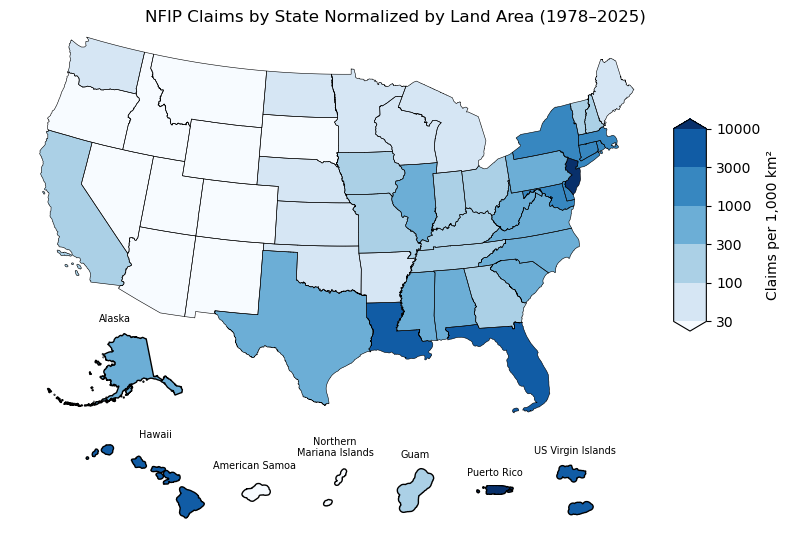

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
boundaries = [30, 100, 300, 1000, 3000, 10000]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, extend='both')

# plot conus values
conus_gdf.plot(
    column='claims_per_1000km2',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.05, 0.25, 0.2, 0.1])
hawaii = fig.add_axes([.0, 0.1, 0.4, 0.15])
ams = fig.add_axes([.30, 0.1, 0.05, 0.1])
mp = fig.add_axes([.40, 0.1, 0.05, 0.1])
gu = fig.add_axes([.50, 0.1, 0.05, 0.1])
pr = fig.add_axes([.60, 0.1, 0.05, 0.1])
vi = fig.add_axes([.70, 0.1, 0.05, 0.1])
    
# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(700_000)
hawaii.set_ylim(bottom=None, top=1_000_000)
hawaii.set_title('Hawaii', y=.7, fontsize=7)
alaska.axis('off')

cax.set_ylabel('Claims per 1,000 km²', fontsize=10)

fig.suptitle(
    'NFIP Claims by State Normalized by Land Area (1978–2025)',
    fontsize=12,
    y=0.75
)

fig.tight_layout()
fig.savefig('figures/count-claims-norm-map.png', dpi=200, bbox_inches='tight')